# Programma che esegue il fit per 4 componenti (SVD):

Per prima cosa è necessario andare a creare la matrice ridotta con sklearn da cui, passandogli il n° di componenti che vuoi, puoi ricavarti i nuovi vettori che saranno:
- U'= $U \cdot S$;
- V'= $V^T$

In [1]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import os


# Carica il DataFrame
df = pd.read_csv('dati_puliti.csv', sep='\t', header=None)
df_original = pd.read_csv('matrice_con_t.dat', sep=',', header=None)

# Crea un array con le lunghezze d'onda
l_array = df_original.iloc[1:, 0].values
l_array = sorted([float(x.replace(',', '.')) for x in l_array])
l_array = np.array(l_array) # Converti in array numpy x indice


# Funzione per ridurre con SVD
def riduci_svd(matrice, n_componenti):
    svd = TruncatedSVD(n_components=n_componenti)
    U_prime = svd.fit_transform(matrice)  # U'=U*S, fitta il modello cioè calcola comp princ (n_spettri, n_componenti)
    V_prime = svd.components_             # V' (n_componenti, n_colonne (T)) 
    return U_prime, V_prime

# Applica la funzione
U_prime, V_prime = riduci_svd(df, 4)


pd.DataFrame(V_prime).to_csv("V_prime.csv", sep='\t', index=False, header=False)

if not os.path.exists("U_prime.csv"):
    pd.DataFrame(U_prime).to_csv("U_prime.csv", sep='\t', index=False, header=False)

if not os.path.exists("V_prime.csv"):
    pd.DataFrame(V_prime).to_csv("V_prime.csv", sep='\t', index=False, header=False)


# Vediamo come è ordinato l_array
print("Lunghezze d'onda ordinate:")
print(l_array)

Lunghezze d'onda ordinate:
[220.  220.5 221.  221.5 222.  222.5 223.  223.5 224.  224.5 225.  225.5
 226.  226.5 227.  227.5 228.  228.5 229.  229.5 230.  230.5 231.  231.5
 232.  232.5 233.  233.5 234.  234.5 235.  235.5 236.  236.5 237.  237.5
 238.  238.5 239.  239.5 240.  240.5 241.  241.5 242.  242.5 243.  243.5
 244.  244.5 245.  245.5 246.  246.5 247.  247.5 248.  248.5 249.  249.5
 250.  250.5 251.  251.5 252.  252.5 253.  253.5 254.  254.5 255.  255.5
 256.  256.5 257.  257.5 258.  258.5 259.  259.5 260.  260.5 261.  261.5
 262.  262.5 263.  263.5 264.  264.5 265.  265.5 266.  266.5 267.  267.5
 268.  268.5 269.  269.5 270.  270.5 271.  271.5 272.  272.5 273.  273.5
 274.  274.5 275.  275.5 276.  276.5 277.  277.5 278.  278.5 279.  279.5
 280.  280.5 281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5
 286.  286.5 287.  287.5 288.  288.5 289.  289.5 290.  290.5 291.  291.5
 292.  292.5 293.  293.5 294.  294.5 295.  295.5 296.  296.5 297.  297.5
 298.  298.5 299.  299.5

Ora al fine di fare un fit globale, visto che i parametri in gioco sono molti è necessario fare delle consideraizoni.
L'obiettivo è quello di fare un fit globale delle prime n componenti $V'_i$ con le funzioni $f_i(x)$;
- DoveLa funzione fitted \( f_i(T) \) per ciascuna componente SVD è definita come:

$$
f_i(T) = \sum_{j=1}^{4} C_{ij} \cdot M_j(T)
$$

dove:
- $ i = 1, 2, 3, 4 $ rappresenta le componenti principali $ V'_1, V'_2, V'_3 V'_4$;
- $ j = 1, 2, 3, 4 $ rappresenta gli stati conformazionali:
  - $ M_1(T) $: stato Folded
  - $ M_2(T) $: stato Intermedio 1
  - $ M_3(T) $: stato Intermedio 2
  - $ M_4(T) $: stato Unfolded
- $ C_{ij} $ sono i coefficienti di pesatura per ciascuna componente

e, di nuovo, $M_i(x)$ sono le equazioni di Van't Hoff, definite in questo modo:
1) $ M_{1} = \frac {1}{denom} $
2) $ M_{2} = \frac {A}{denom}$
3) $ M_{3} = \frac {A \cdot B}{denom}$
4) $ M_{4} = \frac {A \cdot B \cdot C}{denom}$

ed: A,B, C definiti:

1) $ A = exp(- \frac {\Delta H_{1}} {R}) \cdot ((\frac{1}{T_{m1}}- \frac {1}{T})$;
2) $ B = exp(- \frac {\Delta H_{2}} {R}) \cdot ((\frac{1}{T_{m2}}- \frac {1}{T})$
3) $ C = exp(- \frac {\Delta H_{3}} {R}) \cdot ((\frac{1}{T_{m3}}- \frac {1}{T})$

Questo risulta come ho accennato complicato e perciò si ricorre ad un trucco per fissare alcuni parametri; 
Se nel caso in esempio le componenti principali sono 4 (e di conseguenza gli stati del G4 sono 3 F<->I1<->I2<->U) allora il numero di coefficienti da fissare sarà 25: 
- 3 Tm;
- 3 $ \Delta H$;
- 16 coefficienti $C_{ij}$;

Quindi avendo a disposizione lo spettro F (a T più bassa), e quello U (a T più alta) si esegue un fit locale della forma generale di U' sullo spettro:
$$Spettro_{F,20°}= C_{11} \cdot U_1 + C_{21} \cdot U_2 + C_{31} \cdot U_3 + C_{41} \cdot U_4$$

$$Spettro_{U,100°}= C_{14} \cdot U_1 + C_{24} \cdot U_2 + C_{34} \cdot U_3 + C_{44} \cdot U_4$$

In questo modo riusciremo a tenere fissi 6 coefficienti che renderanno il fit globale più semplice.

Tiriamoci fuori i vettori U' e V', intanto:

In [2]:
print("U' :")
print(U_prime[:5])  # prime 5 righe, tutte le colonne (3)

print("\nV' :")
print(V_prime[:, :5])  # tutte le righe (componenti=3), prime 5 colonne

U' :
[[ 2.69331699  1.33681865  0.58036215 -0.12388134]
 [ 2.70151002  1.35211253  0.55754394 -0.1267375 ]
 [ 2.69897776  1.338653    0.54448069 -0.13233767]
 [ 2.71370092  1.32491943  0.52856091 -0.15115937]
 [ 2.72083933  1.31437191  0.51963295 -0.16333111]]

V' :
[[ 0.22373312  0.22222738  0.22239197  0.2230658   0.22206521]
 [-0.08993846 -0.09048225 -0.09096013 -0.08846254 -0.09441222]
 [ 0.17829132  0.13011098  0.11829706  0.11822235  0.12455893]
 [-0.21709662 -0.18293259 -0.18047055 -0.22609717 -0.15265976]]


Ora andiamo a fittare la forma di U con lo spettro:

Coefficenti della regressione: C11=0.22421885840014702, C21=-0.08956113530675706, C31=0.1772721707350763, C41=-0.22984703654243324


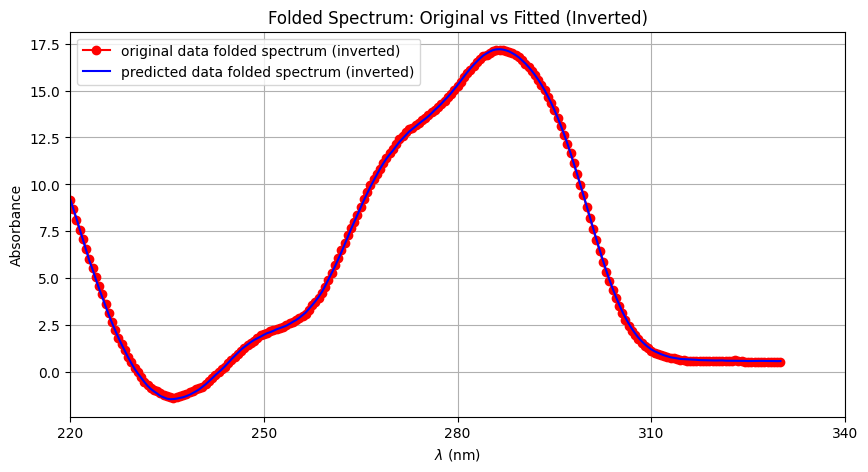

In [3]:
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import pyplot as plt

spttr_F= df.iloc [:,0 ].values  # escludi la prima colonna (lunghezze d'onda)

reg = LinearRegression()

# Fit il modello direttamente senza ordinamento
reg.fit(U_prime, spttr_F)

# Coefficienti
C11, C21, C31, C41 = reg.coef_
print(f"Coefficenti della regressione: C11={C11}, C21={C21}, C31={C31}, C41={C41}")

# Predizione dei dati
predicted_F = reg.predict(U_prime)

# Invertiamo solo i dati di `spttr_F` e `predicted`, ma lasciamo `l_array` invariato
spttr_F_reversed = spttr_F[::-1]
predicted_reversed_F = predicted_F[::-1]


# Grafico
plt.figure(figsize=(10, 5))

# Grafico dei dati originali
plt.plot(l_array, spttr_F_reversed, label='original data folded spectrum (inverted)', marker='o', color='red')

# Grafico dei dati predetti
plt.plot(l_array, predicted_reversed_F, label='predicted data folded spectrum (inverted)', linestyle='-', color='blue')

# Titolo e etichette
plt.title('Folded Spectrum: Original vs Fitted (Inverted)')
plt.xlabel(r'$\lambda$ (nm)')
plt.xlim(min(l_array), max(l_array))
step_size = 30
ticks = np.arange(min(l_array), max(l_array) + step_size, step_size)
plt.xticks(ticks)

plt.ylabel('Absorbance')
plt.grid(True)
plt.legend()
plt.show()


Coefficenti:
C14: 0.024022737585642624, C24: 0.1549127585099902, C34: 0.29989564070679553, C44: 0.2833329184362483


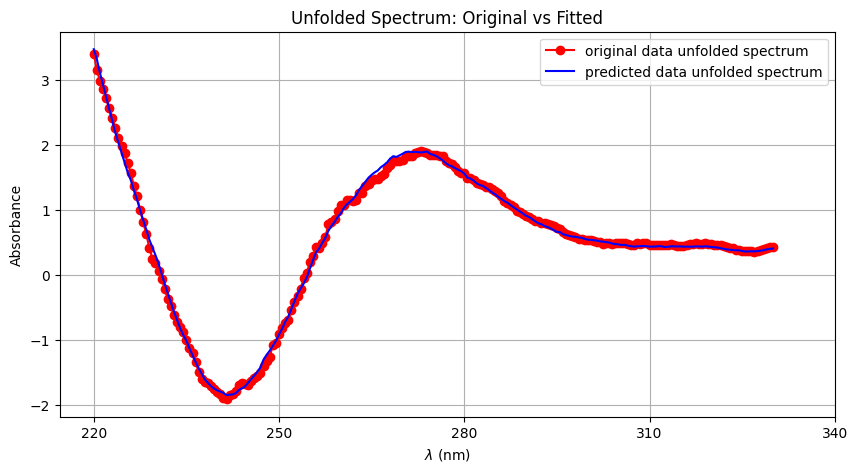

In [4]:
spttr_U = df.iloc[:, -1].values # ultima colonna (spettro unfolded)
reg.fit(U_prime, spttr_U)  # addestra il modello
C14,C24,C34,C44 = reg.coef_  # coefficenti
predicted_U = reg.predict(U_prime)  # predizione
print("\nCoefficenti:")
print(f"C14: {C14}, C24: {C24}, C34: {C34}, C44: {C44}")

spttr_U_reversed = spttr_U[::-1]
predicted_reversed_U = predicted_U[::-1]

plt.figure(figsize=(10, 5))
plt.plot(l_array, spttr_U_reversed, label= 'original data unfolded spectrum', marker='o', color='red')
plt.plot(l_array, predicted_reversed_U, label= 'predicted data unfolded spectrum', linestyle='-', color='blue')
plt.title('Unfolded Spectrum: Original vs Fitted')
plt.xlabel(r'$\lambda$ (nm)')
step_size = 30
ticks = np.arange(min(l_array), max(l_array) + step_size, step_size)
plt.xticks(ticks)
plt.ylabel('Absorbance')
plt.grid(True)
plt.legend()
plt.show()

Ora abbiamo i primi 6 coefficienti.
Ci resta solamente da fare il fit globale grazie alle funzioni di Van't Hoff.

In [5]:
# Creazione array per le temperature
t_csv = pd.read_csv('matrice_con_t.dat', sep=',', header=None)
t_array = t_csv.iloc[0, 1:].astype(float).values # prima riga, da 2 in poi
T_kelvin = t_array + 273.15

R = 1.987  # cal/(mol·K)

print("\nTemperatura (K):")
print(T_kelvin[:5])  # prime 5 righe


Temperatura (K):
[292.15 295.15 297.15 299.15 301.15]


Qui è stato fatto un global-fit per il modello F<->I1<->I2<->U.
In cui è ovviamante sono presenti 2 stadi intermedio tra la conformazione Folded and Unfolded. 

**MODELLO SEQUENZIALE**

In [6]:
def calc_M_4_s(T, Tm1, Tm2, Tm3, dH1, dH2, dH3):
    """
    Calcola le frazioni M1, M2, M3, M4 per un sistema con 3 transizioni termodinamiche in sequenza:
    S1 <-> S2 <-> S3 <-> S4
    """
    A = np.exp(-dH1 / R * (1/Tm1 - 1/T))
    B = np.exp(-dH2 / R * (1/Tm2 - 1/T))
    C = np.exp(-dH3 / R * (1/Tm3 - 1/T))

    denom = 1 + A + A*B + A*B*C

    M1 = 1 / denom
    M2 = A / denom
    M3 = A * B / denom
    M4 = A * B * C / denom

    return np.stack([M1, M2, M3, M4], axis=0)  # shape (4, len(T))


from scipy.optimize import least_squares

def residui_4_s(params, T, V_prime, C_fix): # una funzione che restituisce SOLO la differenza tra i dati e il modello ma serve per far andare LeastSquares
    
    # costruisce C
    # calcola M_i(T) per i tre stati -> M
    # calcola f_i(T) = sum_j C_ij * M_j(T) -> f_pred
    # calcola residui = V_prime - f_pred -> residui

    Tm1 = params[0]
    Tm2 = Tm1 + np.abs(params[1])
    Tm3 = Tm2 + np.abs(params[2])
    dH1, dH2, dH3 = params[3:6]
    C12, C22, C32, C42, C13, C23, C33, C43 = params[6:]



    # ricostruisci tutti i Cij
    C = np.array([
        [C_fix['C11'],  C12, C13,  C_fix['C14']],
        [C_fix['C21'],  C22, C23,  C_fix['C24']],
        [C_fix['C31'],  C32, C33,  C_fix['C34']],
        [C_fix['C41'],  C42, C43,  C_fix['C44']]
    ])  # shape (4, 4)

    # calcolo le M_i(T)
    M = calc_M_4_s(T, Tm1, Tm2, Tm3, dH1, dH2, dH3)  # shape (4, len(T))

    # calcolo f_i(T) = sum_j C_ij * M_j(T)
    f_pred = C @ M  # shape (4, len(T))

    # flatten dei residui
    return (V_prime - f_pred).flatten()


# dizionario dei C fissi (già calcolati)
C_fix = {
    'C11': C11,
    'C21': C21,
    'C31': C31,
    'C41': C41,
    'C14': C14,
    'C24': C24,
    'C34': C34,
    'C44': C44
}

# valori per i parametri termodinamici presi circa da letteratura
p0 = [
    330, 10, 10,              # Tm1, dT1, dT2 (differenze positive!)
    -20000, -28000, -35000,  # ΔH1, ΔH2, ΔH3
    0.3, 0.3, 0.3, 0.3,       # C12–C42
    0.3, 0.3, 0.3, 0.3        # C13–C43
]


residui_init = residui_4_s(p0, T_kelvin, V_prime, C_fix)
print("Valori iniziali dei residui:", residui_init[:10])
print("Contengono NaN?", np.any(np.isnan(residui_init)))
print("Contengono inf?", np.any(np.isinf(residui_init)))


# prova params fino a che sono minimi (1000) residui_p
# poi salva i params ottimizzati in res.x


res_s = least_squares( # chiama i residui con diversi params (prove)e trova i valori ottimali, al termine trovi tutto su res.x
    residui_4_s,
    p0,
    args=(T_kelvin, V_prime, C_fix),
    method='trf',  # Trust Region Reflective 'trf' è il metodo di Levenberg-Marquardt
    bounds=(
        [300, 1, 1, -50000, -50000, -50000, -10, -10, -10, -10, -10, -10, -10, -10],  # lower
        [400, 100, 100,  -1000, -1000, -1000,  10,  10,  10,  10,  10,  10,  10,  10]        # upper
    )
)




# Estrai i parametri "veri" (ricostruiti) da res_p.x
Tm1_opt = res_s.x[0]
Tm2_opt = Tm1_opt + np.abs(res_s.x[1])
Tm3_opt = Tm2_opt + np.abs(res_s.x[2])
rest_opt = res_s.x[3:]  # gli altri parametri

# Lista per la stampa
values = [Tm1_opt, Tm2_opt, Tm3_opt] + list(rest_opt)
param_labels = ['Tm1', 'Tm2', 'Tm3', 'ΔH1', 'ΔH2', 'ΔH3', 'C12', 'C22', 'C32', 'C42', 'C13', 'C23', 'C33', 'C43']
param_units = ['K', 'K', 'K', 'cal/mol', 'cal/mol', 'cal/mol', '', '', '', '', '', '', '', '']

# Stampa ordinata
print("\nParametri ottimizzati:")
for label, unit, value in zip(param_labels, param_units, values):
    print(f"{label:>4} = {value:10.2f} {unit}")


Valori iniziali dei residui: [-0.00191659 -0.00400777 -0.00434781 -0.00429102 -0.00604175 -0.00672205
 -0.00867059 -0.00971586 -0.01102878 -0.01433031]
Contengono NaN? False
Contengono inf? False

Parametri ottimizzati:
 Tm1 =     332.22 K
 Tm2 =     333.22 K
 Tm3 =     351.97 K
 ΔH1 =  -17808.01 cal/mol
 ΔH2 =  -33583.67 cal/mol
 ΔH3 =  -33027.92 cal/mol
 C12 =       0.23 
 C22 =       0.11 
 C32 =      -0.67 
 C42 =       1.27 
 C13 =       0.01 
 C23 =       0.34 
 C33 =      -0.17 
 C43 =      -0.68 


Il grafico connesso al fit con il chi quadro ridotto:

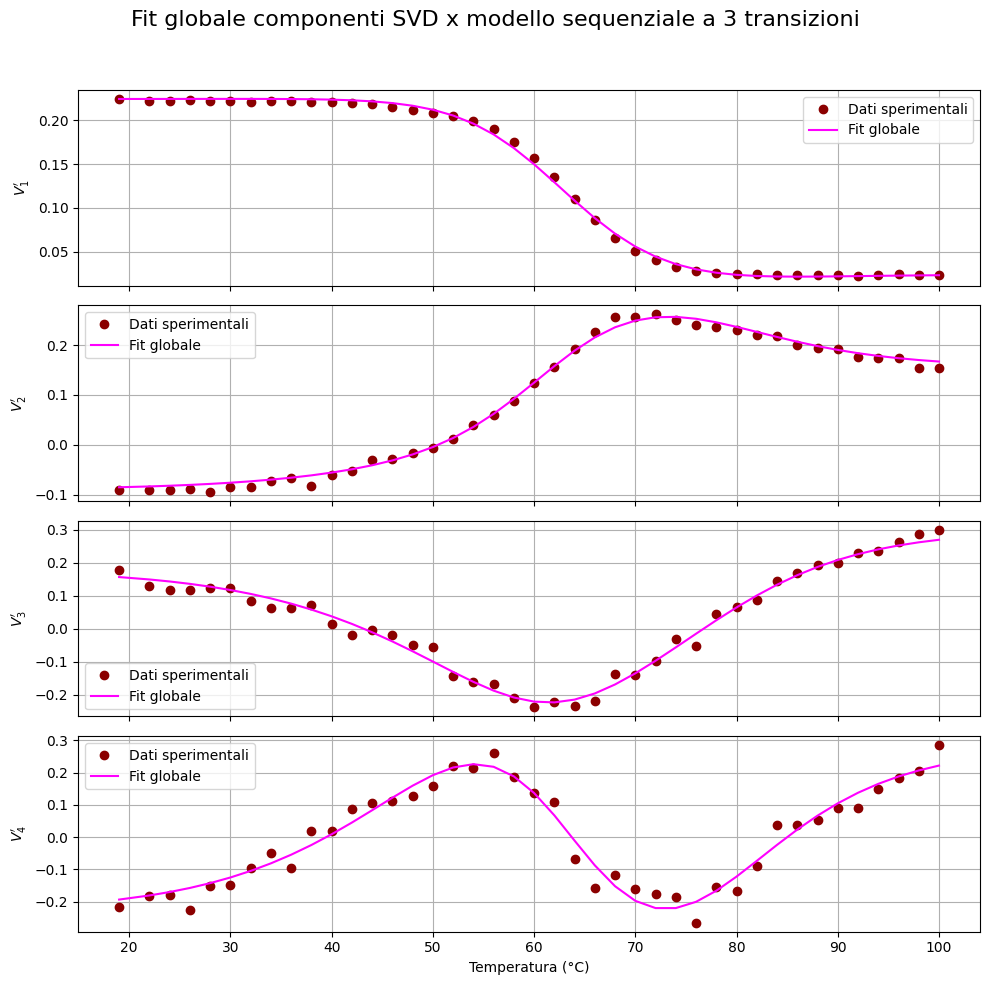


Chi quadro ridotto (modello sequenziale): 0.00046


In [7]:
# Estrazione dei parametri ottimizzati
Tm1_opt = res_s.x[0]
Tm2_opt = Tm1_opt + np.abs(res_s.x[1])
Tm3_opt = Tm2_opt + np.abs(res_s.x[2])
dH1_opt, dH2_opt, dH3_opt = res_s.x[3:6]
C12, C22, C32, C42, C13, C23, C33, C43 = res_s.x[6:]

# Ricostruzione della matrice C ottimizzata (4x4)
C_opt = np.array([
    [C_fix['C11'], C12,  C13,  C_fix['C14']],
    [C_fix['C21'], C22,  C23,  C_fix['C24']],
    [C_fix['C31'], C32,  C33,  C_fix['C34']],
    [C_fix['C41'], C42,  C43,  C_fix['C44']]
])

# Calcolo delle M ottimizzate (shape: 4 x len(T))
M_opt = calc_M_4_s(T_kelvin, Tm1_opt, Tm2_opt, Tm3_opt, dH1_opt, dH2_opt, dH3_opt)

# Calcolo delle predizioni f_i(T)
f_pred_s = C_opt @ M_opt  # shape: 4 x len(T)

# Calcolo chi quadro ridotto
residuals = V_prime - f_pred_s
chi2 = np.sum(residuals**2)
dof = V_prime.size - len(res_s.x)
chi2_red = chi2 / dof

# Plot dei risultati
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$", r"$V_4'$"]

for i in range(4):
    axs[i].plot(t_array, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(t_array, f_pred_s[i], '-', label='Fit globale', color='magenta')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[3].set_xlabel("Temperatura (°C)")
plt.suptitle(r"Fit globale componenti SVD x modello sequenziale a 3 transizioni", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Output del chi quadro ridotto
print(f"\nChi quadro ridotto (modello sequenziale): {chi2_red:.5f}")


**N.B.:** $\chi^2$ ridotto così piccolo normalmente indicherebbe un overfitting per assenza di rumore ma nel nostro caso stiamo filtrando il rumore con la tecnica SVD e quindi vogliamo che il  $\chi^2$ ridotto sia così piccolo.

Di seguito, invece, si considera di fittare per il modello F<->I1/I2<->U.
                                                            

**MODELLO PARALLELO**

In [8]:
def calc_M_4_p(T, Tm1, Tm2, Tm3, dH1, dH2, dH3):
    """
    Calcola le frazioni M1, M2, M3, M4 per un modello parallelo a 3 stati intermedi:
    Su <-> S1, Su <-> S2, Su <-> S3 (indipendenti tra loro).
    Si assume che:
    - Su = stato iniziale (unico)
    - S1, S2, S3 = stati intermedi
    - S4 = stato finale (comune o cumulativo)

    Il modello assume partenza da uno stato comune e che le transizioni avvengano in parallelo.
    """

    # Protezione per evitare overflow numerico
    def safe_exp(x, max_exp=700):
        x_clipped = np.clip(x, -max_exp, max_exp)
        return np.exp(x_clipped)


    # Equilibri indipendenti per ciascuna transizione
    A = safe_exp(-dH1 / R * (1/Tm1 - 1/T))  # Su <-> S1
    B = safe_exp(-dH2 / R * (1/Tm2 - 1/T))  # Su <-> S2
    C = safe_exp(-dH3 / R * (1/Tm3 - 1/T))  # Su <-> S3

    # Denominatore totale (partition function)
    denom = 1 + A + B + C

    # Frazioni: ciascuno rispetto al totale
    M1 = 1 / denom       # Stato iniziale Su
    M2 = A / denom       # Stato S1
    M3 = B / denom       # Stato S2
    M4 = C / denom       # Stato S3

    return np.stack([M1, M2, M3, M4], axis=0)  # shape (4, len(T))


def residui_4_p(params, T, V_prime, C_fix): # una funzione che restituisce SOLO la differenza tra i dati e il modello ma serve per far andare LeastSquares
    
    # costruisce C
    # calcola M_i(T) per i tre stati -> M
    # calcola f_i(T) = sum_j C_ij * M_j(T) -> f_pred
    # calcola residui = V_prime - f_pred -> residui

    Tm1, Tm2, Tm3, dH1, dH2, dH3 = params[:6]
    C12, C22, C32, C42, C13, C23, C33, C43 = params[6:]



    # ricostruisci tutti i Cij
    C = np.array([
        [C_fix['C11'],  C12, C13,  C_fix['C14']],
        [C_fix['C21'],  C22, C23,  C_fix['C24']],
        [C_fix['C31'],  C32, C33,  C_fix['C34']],
        [C_fix['C41'],  C42, C43,  C_fix['C44']]
    ])  # shape (4, 4)

    # calcolo le M_i(T)
    M = calc_M_4_p(T, Tm1, Tm2, Tm3, dH1, dH2, dH3)  # shape (4, len(T))

    # calcolo f_i(T) = sum_j C_ij * M_j(T)
    f_pred = C @ M  # shape (4, len(T))

    # flatten dei residui
    return (V_prime - f_pred).flatten()


# dizionario dei C fissi (già calcolati)
C_fix = {
    'C11': C11,
    'C21': C21,
    'C31': C31,
    'C41': C41,
    'C14': C14,
    'C24': C24,
    'C34': C34,
    'C44': C44
}

# valori per i parametri termodinamici presi circa da letteratura
p0 = [
    330, 340, 360,              # Tm1, Tm2 e Tm3
    -20000, -28000, -35000,  # ΔH1, ΔH2, ΔH3
    0.3, 0.3, 0.3, 0.3,       # C12–C42
    0.3, 0.3, 0.3, 0.3        # C13–C43
]


residui_init = residui_4_p(p0, T_kelvin, V_prime, C_fix)
print("Valori iniziali dei residui:", residui_init[:10])
print("Contengono NaN?", np.any(np.isnan(residui_init)))
print("Contengono inf?", np.any(np.isinf(residui_init)))


# prova params fino a che sono minimi (1000) residui_p
# poi salva i params ottimizzati in res.x


res_p = least_squares( # chiama i residui con diversi params (prove)e trova i valori ottimali, al termine trovi tutto su res.x
    residui_4_p,
    p0,
    args=(T_kelvin, V_prime, C_fix),
    method='trf',  # Trust Region Reflective 'trf' è il metodo di Levenberg-Marquardt
)


# Lista per la stampa
values = [res_p.x[0], res_p.x[1], res_p.x[2], res_p.x[3], res_p.x[4], res_p.x[5], res_p.x[6], res_p.x[7], res_p.x[8], res_p.x[9], res_p.x[10], res_p.x[11], res_p.x[12], res_p.x[13]]
param_labels = ['Tm1', 'Tm2', 'Tm3', 'ΔH1', 'ΔH2', 'ΔH3', 'C12', 'C22', 'C32', 'C42', 'C13', 'C23', 'C33', 'C43']
param_units = ['K', 'K', 'K', 'cal/mol', 'cal/mol', 'cal/mol', '', '', '', '', '', '', '', '']

# Stampa ordinata
print("\nParametri ottimizzati:")
for label, unit, value in zip(param_labels, param_units, values):
    print(f"{label:>4} = {value:10.2f} {unit}")

Valori iniziali dei residui: [-0.00199483 -0.00413185 -0.00451467 -0.00451319 -0.00633428 -0.00710239
 -0.00915803 -0.01033026 -0.01178836 -0.01524825]
Contengono NaN? False
Contengono inf? False

Parametri ottimizzati:
 Tm1 =     336.60 K
 Tm2 =     333.13 K
 Tm3 =     340.62 K
 ΔH1 =  -16959.54 cal/mol
 ΔH2 =  -49964.64 cal/mol
 ΔH3 =  -83572.07 cal/mol
 C12 =       0.24 
 C22 =       0.14 
 C32 =      -0.87 
 C42 =       1.64 
 C13 =       0.01 
 C23 =       0.33 
 C33 =      -0.15 
 C43 =      -0.65 


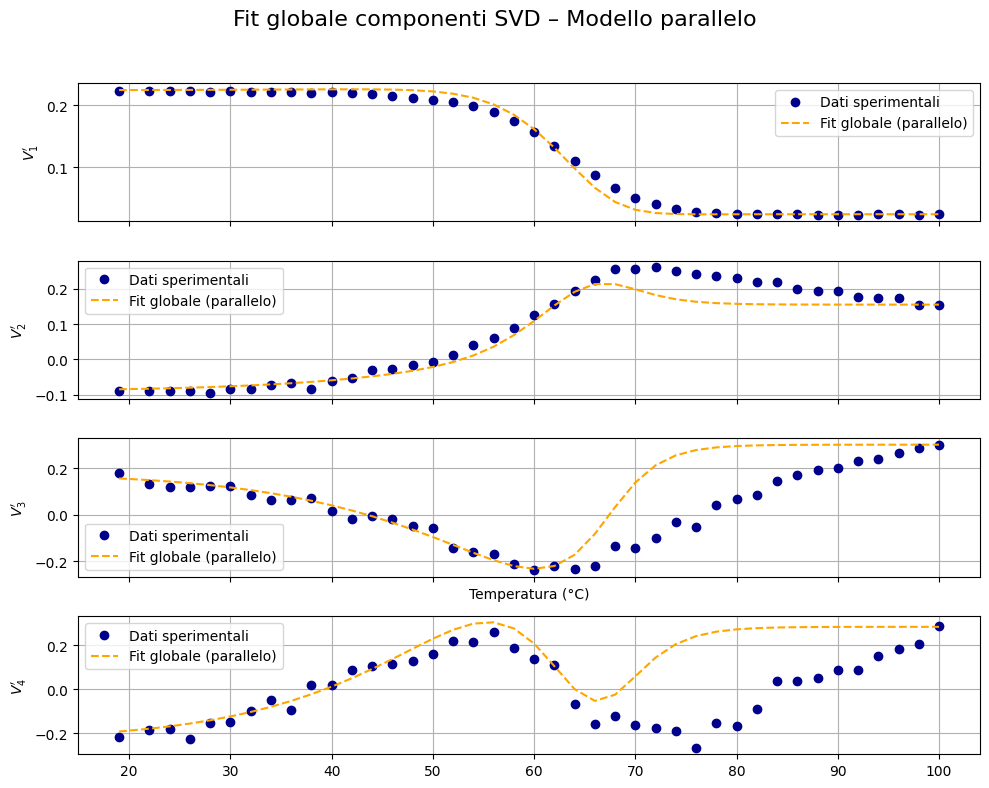


Chi quadro ridotto (modello parallelo): 0.01415


In [9]:
# Estrai i parametri ottimizzati
Tm1_p = res_p.x[0]
Tm2_p = res_p.x[1]
Tm3_p = res_p.x[2]
dH1_p, dH2_p, dH3_p = res_p.x[3:6]
C12_p, C22_p, C32_p, C42_p = res_p.x[6:10]
C13_p, C23_p, C33_p, C43_p = res_p.x[10:]

# Ricostruisci la matrice C ottimizzata (4x4)
C_opt_p = np.array([
    [C_fix['C11'], C12_p, C13_p, C_fix['C14']],
    [C_fix['C21'], C22_p, C23_p, C_fix['C24']],
    [C_fix['C31'], C32_p, C33_p, C_fix['C34']],
    [C_fix['C41'], C42_p, C43_p, C_fix['C44']]
])

# Calcola le M_i(T) con i parametri ottimizzati
M_opt_p = calc_M_4_s(T_kelvin, Tm1_p, Tm2_p, Tm3_p, dH1_p, dH2_p, dH3_p)  # shape (4, len(T))

# Calcola f_pred = C @ M
f_pred_p = C_opt_p @ M_opt_p  # shape (4, len(T))

# Calcolo chi quadro ridotto
residuals_p = V_prime - f_pred_p
chi2_p = np.sum(residuals_p**2)
dof_p = V_prime.size - len(res_p.x)
chi2_red_p = chi2_p / dof_p

# Plot
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$", r"$V_4'$"]

for i in range(4):
    axs[i].plot(t_array, V_prime[i], 'o', label='Dati sperimentali', color='darkblue')
    axs[i].plot(t_array, f_pred_p[i], '--', label='Fit globale (parallelo)', color='orange')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(r"Fit globale componenti SVD – Modello parallelo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Output chi^2 ridotto
print(f"\nChi quadro ridotto (modello parallelo): {chi2_red_p:.5f}")


Per ultima cosa confrontiamo visivamente i due fit per capire (anche se risulta già chiaro) quale modello si adatta in maniera migliore al caso in esame

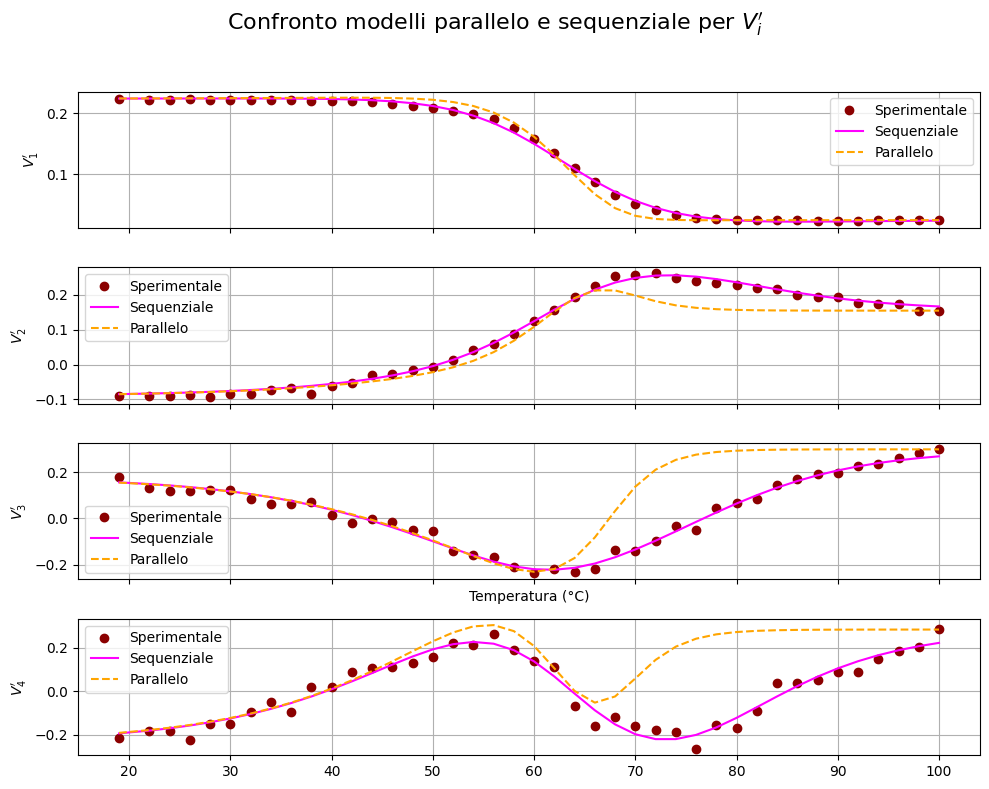

In [10]:
# Grafico comparativo dei due modelli
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$", r"$V_4'$"]

for i in range(4):
    axs[i].plot(t_array, V_prime[i], 'o', label='Sperimentale', color='darkred')
    axs[i].plot(t_array, f_pred_s[i], '-', label='Sequenziale', color='magenta')
    axs[i].plot(t_array, f_pred_p[i], '--', label='Parallelo', color='orange')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Temperatura (°C)")
plt.suptitle(
    rf"Confronto modelli parallelo e sequenziale per $V_i'$", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Ora io ho fittato i due modelli e capito quale dei due è il caso che sto studiando.
Noto che il modello sequenziale fitta già bene gli 'amplitude vectors' V.

Richiamo la funzione che avevo ottimizzato f_pred_s e la fitto lasciando i parametri precedentemente fissati come liberi e quelli liberi fissati.

Per essere il più precisi possibile si è deciso di fare un secondo fit dove si tengono liberi i parametri precedentemente fissati (stato folded e unfolded) e fissi quelli che prima si erano tenuti liberi. Tutto questo vale tranne per dT1 (e di conseguenza dH1) parametro che definisce Tm2 in quanto fisicamente viene molto piccolo e si spera che con questo secondo fit il valore salga.

In [11]:
# Parametri da fissare (dati dal primo fit)
Tm1 = res_s.x[0]                    # fisso
dH2, dH3 = res_s.x[4:6]          # fissi
Cij_intermedi = res_s.x[6:]  # fissi: C12, C22, ..., C43

# Parametri da ottimizzare
# [dT1, dT2, ΔH1, C11, C14, C21, C24, C31, C34, C41, C44]
refit_p0 = [
    res_s.x[1],              # dT1
    res_s.x[2],              # dT2
    res_s.x[3],                  # ΔH1
    C11, C14, C21, C24, C31, C34, C41, C44
]

def residui_refit2(params, T, V_prime, Cij_intermedi):
    dT1, dT2, dH1 = params[:3]
    C11, C14, C21, C24, C31, C34, C41, C44 = params[3:]

    Tm2 = Tm1 + abs(dT1)
    Tm3 = Tm2 + abs(dT2)

    # Parametri intermedi fissi
    C12, C22, C32, C42, C13, C23, C33, C43 = Cij_intermedi

    # Costruzione matrice C completa
    C = np.array([
        [C11, C12, C13, C14],
        [C21, C22, C23, C24],
        [C31, C32, C33, C34],
        [C41, C42, C43, C44]
    ])

    M = calc_M_4_s(T, Tm1, Tm2, Tm3, dH1, dH2, dH3)
    f_pred = C @ M

    return (V_prime - f_pred).flatten()

# Fit finale
res_final = least_squares(
    residui_refit2,
    refit_p0,
    args=(T_kelvin, V_prime, Cij_intermedi),
    method='trf',
    bounds=(
        [1, 1, -50000, -10, -10, -10, -10, -10, -10, -10, -10],     # lower
        [80, 80, -1000, 10, 10, 10, 10, 10, 10, 10, 10]             # upper
    )
)

# Estrazione risultati
dT1_fit, dT2_fit, dH1_fit = res_final.x[:3]
Tm2_fit = Tm1 + abs(dT1_fit)
Tm3_fit = Tm2_fit + abs(dT2_fit)
C_fit_vals = res_final.x[3:]
C_fit_labels = ['C11', 'C14', 'C21', 'C24', 'C31', 'C34', 'C41', 'C44']

# Stampa risultati
print("\nParametri rifittati (dT1, dT2, ΔH1, Cij terminali):")
print(f"T1  = {Tm1:.2f} K (fisso)")
print(f"T2  = {Tm2_fit:.2f} K")
print(f"T3  = {Tm3_fit:.2f} K")
print(f"ΔH1 = {dH1_fit:.2f} cal/mol")
for label, val in zip(C_fit_labels, C_fit_vals):
    print(f"{label} = {val:.4f}")



Parametri rifittati (dT1, dT2, ΔH1, Cij terminali):
T1  = 332.22 K (fisso)
T2  = 333.39 K
T3  = 352.36 K
ΔH1 = -16539.24 cal/mol
C11 = 0.2218
C14 = 0.0249
C21 = -0.0982
C24 = 0.1464
C31 = 0.1837
C34 = 0.3139
C41 = -0.2577
C44 = 0.2922


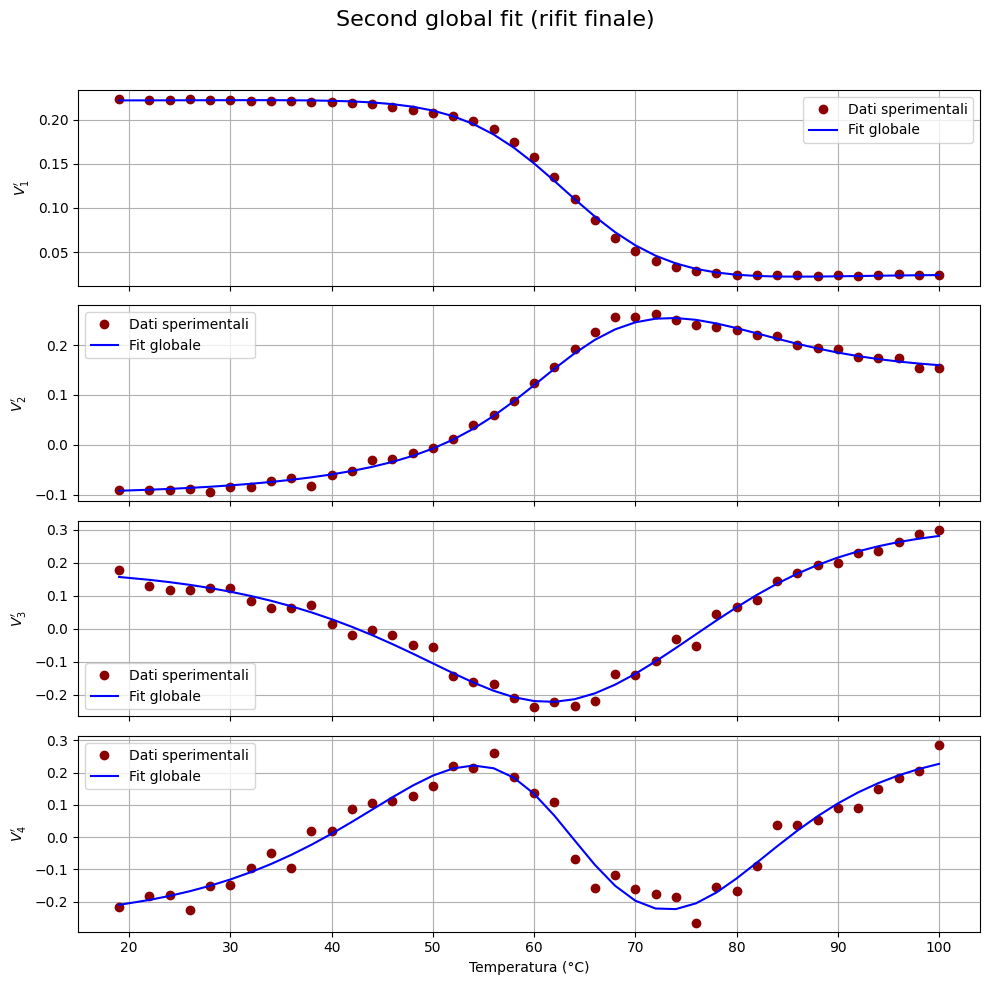


Chi quadro ridotto: 0.00043


In [12]:
# Estrazione dei parametri rifittati
dT1_fit, dT2_fit, dH1_fit = res_final.x[:3]
Tm2_fit = Tm1 + abs(dT1_fit)
Tm3_fit = Tm2_fit + abs(dT2_fit)

# Coefficienti rifittati (Cij terminali)
C11, C14, C21, C24, C31, C34, C41, C44 = res_final.x[3:]

# Coefficienti intermedi fissi (Cij centrali)
Cij_intermedi = res_s.x[6:]  # ordine: C12, C22, C32, C42, C13, C23, C33, C43
C12, C22, C32, C42, C13, C23, C33, C43 = Cij_intermedi

# Ricostruzione matrice C rifittata
C_rifit = np.array([
    [C11, C12, C13, C14],
    [C21, C22, C23, C24],
    [C31, C32, C33, C34],
    [C41, C42, C43, C44]
])

# Calcolo M e predizione f_pred
M_opt_secfit = calc_M_4_s(T_kelvin, Tm1, Tm2_fit, Tm3_fit, dH1_fit, dH2, dH3)
f_pred_secfit = C_rifit @ M_opt_secfit

# Calcolo del chi quadro ridotto
residuals = V_prime - f_pred_secfit
chi2 = np.sum(residuals**2)
dof = V_prime.size - len(res_final.x)
chi2_red = chi2 / dof

# Plot
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
labels = [r"$V_1'$", r"$V_2'$", r"$V_3'$", r"$V_4'$"]

for i in range(4):
    axs[i].plot(T_kelvin - 273.15, V_prime[i], 'o', label='Dati sperimentali', color='darkred')
    axs[i].plot(T_kelvin - 273.15, f_pred_secfit[i], '-', label='Fit globale', color='blue')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)
    axs[i].legend()

axs[3].set_xlabel("Temperatura (°C)")
plt.suptitle("Second global fit (rifit finale)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"\nChi quadro ridotto: {chi2_red:.5f}")


Per ultima cosa, salvo i parametri ottimizzati (tutti e 13), in un file csv che useremo nel prossimo programma al fine di ricostruire gli spettri.

In [13]:
# salva i parametri ottimizzati in un file CSV
parametri_ottimizzati = pd.DataFrame({
    'Parametri': ['Tm1', 'Tm2', 'Tm3', 'dH1', 'dH2', 'dH3', 'C11', 'C12', 'C13', 'C14','C21', 'C22', 'C23', 'C24', 'C31', 'C32', 'C33', 'C34', 'C41', 'C42', 'C43', 'C44'],   
    'Valori': [Tm1 , Tm2_fit, Tm3_fit, dH1_fit, dH2, dH3, C11, C12, C13, C14, C21, C22, C23, C24, C31, C32, C33, C34, C41, C42, C43, C44]
})

parametri_ottimizzati.head()

,Parametri,Valori
0,Tm1,332.221288
1,Tm2,333.388078
2,Tm3,352.357581
3,dH1,-16539.238503
4,dH2,-33583.674143


In [14]:
if not os.path.exists("parametri_ottimizzati.csv"):
    parametri_ottimizzati.to_csv("parametri_ottimizzati.csv", sep='\t', index=False, header=False)

if not os.path.exists("M_matrix.csv"):
    pd.DataFrame(M_opt_secfit).to_csv("M_matrix.csv", sep='\t', index=False, header=False)